In [2]:
!pip install openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.0/250.0 kB 24.7 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import math
import openpyxl
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [5]:
file_path = "data/ESG_raw_data_07_02.xlsx"
file_sect = "data/secteurs.csv"
corresp_secteurs = pd.read_csv(file_sect, sep=";")
data = pd.read_excel(file_path)
data = data.join(corresp_secteurs.set_index('primary_industry'), on = "primary_industry")

In [6]:
secteurs = pd.unique(data["secteur"])

In [7]:
variables_env = ["scope_1", "scope_2", "scope_3", "waste_production", "waste_recycling", 
                 "water_consumption", "water_withdrawal", "energy_consumption"]

data = data.dropna(subset = ["employees"])
data = data.loc[data["employees"] != 0]
for v in variables_env :
    data[v] = data[v]/data["employees"]

## Matrice de passage

In [63]:
df = data.copy()
df = df.dropna(subset = ["scope_1", "scope_3"])

# Diviser en quartiles pour "scope_1" et "scope_2"
df['scope_1_percentile'] = pd.qcut(df['scope_1'], 10, labels = False)
df['scope_3_percentile'] = pd.qcut(df['scope_3'], 10, labels = False)

# Créer un tableau à double entrée pour compter le nombre d'observations par quartile
pivot_table = pd.crosstab(df['scope_1_percentile'], df['scope_3_percentile'])
display(pivot_table)

scope_3_percentile,0,1,2,3,4,5,6,7,8,9
scope_1_percentile,,,,,,,,,,
0,538,162,58,42,20,30,27,15,14,8
1,110,263,208,114,70,42,31,28,25,22
2,46,118,154,234,153,83,40,30,24,32
3,57,89,121,140,177,130,71,51,38,39
4,55,117,115,92,115,130,123,72,51,44
5,34,63,82,126,139,132,128,99,63,47
6,16,23,59,60,137,158,170,122,103,65
7,31,44,53,35,35,105,168,198,158,87
8,16,19,43,59,45,66,94,201,228,142


In [64]:
# Création des groupes

# Filtrer les conditions pour conserver les lignes correspondantes
condition1 = (df['scope_1_percentile'] < 3) & (df['scope_3_percentile'] >= 7)  # Premier cas
condition2 = (df['scope_1_percentile'] >= 7) & (df['scope_3_percentile'] < 3)  # Deuxième cas

# Conserver les lignes qui répondent à l'une des conditions
df = df[condition1 | condition2]

In [66]:
print(len(df["company_id"][condition1].unique()))

171


In [67]:
print(len(df["company_id"][condition2].unique()))

229


In [68]:
# Maintenant on va régresser le fait d'être dans un groupe ou l'autre sur les variables
df['condition1_met'] = condition1

# Régressions linéaires avec contrôle sur la région et l'année
X = df[['employees', 'region', 'year', 'secteur']]
X = pd.get_dummies(X, columns=['region', 'year', 'secteur'], drop_first=False, dtype=float)
X = X.drop(["region_United States and Canada", "secteur_Real Estate"], axis = 1)
X = sm.add_constant(X)

y = df['condition1_met']

model_clustered = sm.OLS(y, X).fit(cov_type='cluster',
                          cov_kwds={'groups': df['year']})

print(model_clustered.summary())

                            OLS Regression Results                            
Dep. Variable:         condition1_met   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.190
Method:                 Least Squares   F-statistic:                -6.764e+12
Date:                Sat, 27 Apr 2024   Prob (F-statistic):               1.00
Time:                        15:27:36   Log-Likelihood:                -267.10
No. Observations:                 451   AIC:                             572.2
Df Residuals:                     432   BIC:                             650.3
Df Model:                          18                                         
Covariance Type:              cluster                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------

/opt/mamba/lib/python3.11/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 19, but rank is 3
  warnings.warn('covariance of constraints does not have full '


Interprétation : un coefficient positif signifie que la variable augmente (toutes choses égales par ailleurs) la probabilité de vérifier la condition 1 par rapport à la référence (pour les régions c'est les US, pour les secteurs c'est le Real Estate), c'est à dire le fait d'être très bon en scope 1 mais pas en scope 3. 

Comme on pouvait espérer, en Europe on a tendance à vérifier plus cette condition, contrairement à l'Asie. 

On peut avoir le même raisonnement sur les secteurs.

In [69]:
# Construire le modèle logit
model_logit = sm.Logit(y, X)

# Ajuster le modèle avec des erreurs robustes par grappes (clusters)
result_logit = model_logit.fit(cov_type='cluster', cov_kwds={'groups': df['year']})

# Obtenir les effets marginaux moyens
margeff = result_logit.get_margeff()

# Résumé des effets marginaux moyens
print(margeff.summary())

Optimization terminated successfully.
         Current function value: 0.560843
         Iterations 6
        Logit Marginal Effects       
Dep. Variable:         condition1_met
Method:                          dydx
At:                           overall
                                                        dy/dx    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
employees                                           1.982e-06   2.32e-07      8.549      0.000    1.53e-06    2.44e-06
region_Africa / Middle East                           -0.2683      0.019    -14.160      0.000      -0.305      -0.231
region_Asia / Pacific                                 -0.0279      0.004     -6.983      0.000      -0.036      -0.020
region_Europe                                          0.0808      0.037      2.157      0.031       0.007       0.154
region_Latin America and Caribbe

In [70]:
# Construire le modèle probit
model_probit = sm.Probit(y, X)

# Ajuster le modèle avec des erreurs robustes par grappes (clusters)
result_probit = model_probit.fit(cov_type='cluster', cov_kwds={'groups': df['year']})

# Obtenir les effets marginaux moyens
margeff = result_probit.get_margeff()

# Résumé des effets marginaux moyens
print(margeff.summary())

Optimization terminated successfully.
         Current function value: 0.560612
         Iterations 28
       Probit Marginal Effects       
Dep. Variable:         condition1_met
Method:                          dydx
At:                           overall
                                                        dy/dx    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
employees                                           2.028e-06   2.47e-07      8.222      0.000    1.54e-06    2.51e-06
region_Africa / Middle East                           -0.2564      0.024    -10.837      0.000      -0.303      -0.210
region_Asia / Pacific                                 -0.0280      0.004     -7.234      0.000      -0.036      -0.020
region_Europe                                          0.0820      0.040      2.067      0.039       0.004       0.160
region_Latin America and Caribb

On va avoir même raisonnement mais sur les 5 premiers déciles et 5 derniers pour les deux scopes, ça nous permettra de voir quels sont les facteurs d'une entreprise vertueuse et d'une qui l'est pas.

In [9]:
df2 = data.copy()
df2 = df2.dropna(subset = ["scope_1", "scope_3"])

# Diviser en quartiles pour "scope_1" et "scope_2"
df2['scope_1_percentile'] = pd.qcut(df2['scope_1'], 10, labels = False)
df2['scope_3_percentile'] = pd.qcut(df2['scope_3'], 10, labels = False)

# Création des groupes

# Filtrer les conditions pour conserver les lignes correspondantes
condition1 = (df2['scope_1_percentile'] < 5) & (df2['scope_3_percentile'] <5 )  # Premier cas
condition2 = (df2['scope_1_percentile'] >= 5) & (df2['scope_3_percentile'] >= 5)  # Deuxième cas

# Conserver les lignes qui répondent à l'une des conditions
df2 = df2[condition1 | condition2]

In [19]:
print(df2["scope_1"][condition2].mean())

1069.1451912905054


In [23]:
# Maintenant on va régresser le fait d'être dans un groupe ou l'autre sur les variables
df2['condition1_met'] = condition1

# Régressions linéaires avec contrôle sur la région et l'année
X = df2[['employees', 
         "waste_production", 
         "waste_recycling", 
         "water_consumption", 
         "water_withdrawal", 
         #"energy_consumption", 
         'region', 'year', 'secteur']]
X = pd.get_dummies(X, columns=['region', 'year', 'secteur'], drop_first=False, dtype=float)
X = X.drop(["region_United States and Canada", "secteur_Real Estate"], axis = 1)
X = sm.add_constant(X)

mask = ~X.isin([np.nan, np.inf, -np.inf]).any(axis=1)
X = X[mask]

y = df2['condition1_met'][mask]

# Construire le modèle logit
model_logit = sm.Logit(y, X)

# Ajuster le modèle avec des erreurs robustes par grappes (clusters)
result_logit = model_logit.fit(cov_type='cluster', cov_kwds={'groups': df2['year'][mask]})

# Obtenir les effets marginaux moyens
margeff = result_logit.get_margeff()

# Résumé des effets marginaux moyens
print(margeff.summary())

         Current function value: 0.395284
         Iterations: 35
        Logit Marginal Effects       
Dep. Variable:         condition1_met
Method:                          dydx
At:                           overall
                                                        dy/dx    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
employees                                           2.331e-07   8.15e-08      2.860      0.004    7.34e-08    3.93e-07
waste_production                                     8.92e-06   4.54e-07     19.662      0.000    8.03e-06    9.81e-06
waste_recycling                                       -0.0003      0.000     -2.518      0.012      -0.000    -6.2e-05
water_consumption                                  -8.578e-06   5.11e-07    -16.795      0.000   -9.58e-06   -7.58e-06
water_withdrawal                                    2.954e-08   1.54

/opt/mamba/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [24]:
# Construire le modèle probit
model_probit = sm.Probit(y, X)

# Ajuster le modèle avec des erreurs robustes par grappes (clusters)
result_probit = model_probit.fit(cov_type='cluster', cov_kwds={'groups': df2['year'][mask]})

# Obtenir les effets marginaux moyens
margeff = result_probit.get_margeff()

# Résumé des effets marginaux moyens
print(margeff.summary())

         Current function value: 0.396870
         Iterations: 35


/opt/mamba/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


       Probit Marginal Effects       
Dep. Variable:         condition1_met
Method:                          dydx
At:                           overall
                                                        dy/dx    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
employees                                           2.479e-07   7.61e-08      3.256      0.001    9.86e-08    3.97e-07
waste_production                                      5.7e-06   4.85e-07     11.752      0.000    4.75e-06    6.65e-06
waste_recycling                                       -0.0003   7.03e-05     -3.727      0.000      -0.000      -0.000
water_consumption                                  -5.465e-06   5.12e-07    -10.670      0.000   -6.47e-06   -4.46e-06
water_withdrawal                                    7.777e-09   1.45e-08      0.536      0.592   -2.07e-08    3.62e-08
region_Africa /

In [71]:
# On fait pareil en ajoutant les heures de formation

# Régressions linéaires avec contrôle sur la région et l'année
X = df[['employees', 'hours_of_training', 'region', 'year', 'secteur']]
X = pd.get_dummies(X, columns=['region', 'year', 'secteur'], drop_first=False, dtype=float)
X = X.drop(["region_United States and Canada", "secteur_Real Estate"], axis = 1)
X = sm.add_constant(X)

mask = ~X.isin([np.nan, np.inf, -np.inf]).any(axis=1)
X = X[mask]

y = df['condition1_met'][mask]

model_clustered = sm.OLS(y, X).fit(cov_type='cluster',
                          cov_kwds={'groups': df['year'][mask]})

print(model_clustered.summary())

                            OLS Regression Results                            
Dep. Variable:         condition1_met   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     1.370
Date:                Sat, 27 Apr 2024   Prob (F-statistic):              0.422
Time:                        15:27:41   Log-Likelihood:                -107.93
No. Observations:                 186   AIC:                             255.9
Df Residuals:                     166   BIC:                             320.4
Df Model:                          19                                         
Covariance Type:              cluster                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------

/opt/mamba/lib/python3.11/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 20, but rank is 2
  warnings.warn('covariance of constraints does not have full '


Chelou, un peu du mal à interpréter les différences. De toute façon très peu significatif, on a quasiment plus d'observations.

In [72]:
# On fait pareil en ajoutant les heures de formation

# Régressions linéaires avec contrôle sur la région et l'année
X = df[['employees', 'energy_consumption', 'region', 'year', 'secteur']]
X = pd.get_dummies(X, columns=['region', 'year', 'secteur'], drop_first=False, dtype=float)
X = X.drop(["region_United States and Canada", "secteur_Real Estate"], axis = 1)
X = sm.add_constant(X)

mask = ~X.isin([np.nan, np.inf, -np.inf]).any(axis=1)
X = X[mask]

y = df['condition1_met'][mask]

model_clustered = sm.OLS(y, X).fit(cov_type='cluster',
                          cov_kwds={'groups': df['year'][mask]})

print(model_clustered.summary())

                            OLS Regression Results                            
Dep. Variable:         condition1_met   R-squared:                       0.230
Model:                            OLS   Adj. R-squared:                  0.174
Method:                 Least Squares   F-statistic:                -4.577e+11
Date:                Sat, 27 Apr 2024   Prob (F-statistic):               1.00
Time:                        15:27:44   Log-Likelihood:                -165.61
No. Observations:                 280   AIC:                             371.2
Df Residuals:                     260   BIC:                             443.9
Df Model:                          19                                         
Covariance Type:              cluster                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------

/opt/mamba/lib/python3.11/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 20, but rank is 2
  warnings.warn('covariance of constraints does not have full '


Correlation Matrix:
          scope_1   scope_2   scope_3
scope_1  1.000000  0.858811  0.133870
scope_2  0.858811  1.000000  0.149008
scope_3  0.133870  0.149008  1.000000


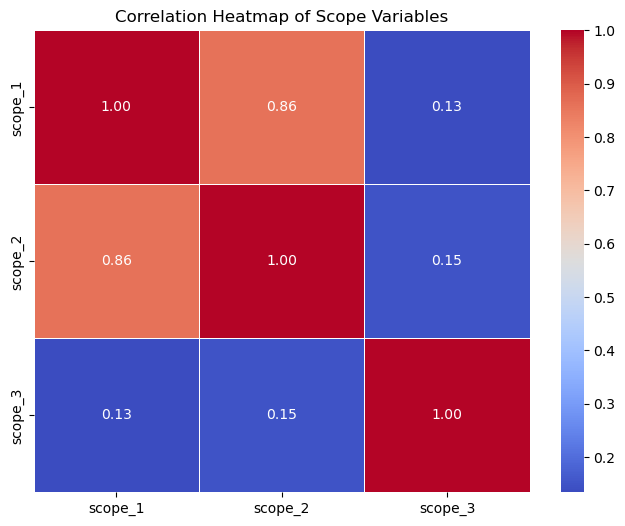

In [8]:
scope_columns = ['scope_1', 'scope_2', 'scope_3']
df2 = data.copy()

for s in scope_columns :
    df2[s] = df2[s]/df2[s].mean()

# Calculate the correlation matrix
correlation_matrix = df2[scope_columns].corr()

# Print the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

import seaborn as sns
import matplotlib.pyplot as plt

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Scope Variables')
plt.show()


## Distributions sectorielles des émissions 

Dans cette partie, on visualise les distributions sectorielles d'émissions. On prend les moyennes des entreprises sur les 3ans étudiés (ou moins si données pas disponibles). On voit rapidement apparaître des "très mauvais élèves" qui tirent la distributions vers la droite et empêchent la bonne visualisation, dans cette partie on se concentre donc sur les entreprises en dessous d'un certain quantile (90%).

In [148]:
def hist(scope, sec, per) :
    df = data.loc[data["secteur"] == sec]
    df = df.dropna(subset = scope)
    df = df.groupby('company_id')[scope].mean().reset_index()
    nbr = df.shape[0]
    
    quantile = df[scope].quantile(1 - per)
    df = df.loc[df[scope] <= quantile]
    nbr = nbr - df.shape[0]
    
    var = df[scope].var()
    mean = df[scope].mean()
    df[scope] = (df[scope]-mean)/np.sqrt(var)
    print(sec + " : " + str(nbr))
    return df

In [180]:
def visualisation_hist(scope, per) :
    plt.figure(figsize=(12, 20))
    print("Nombres d'entreprises mises de côté par secteur, en prenant le quantile " + str(100*(1 - per)) + "%")
    
    i = 1
    for s in secteurs :
        df = hist(scope, s, per)
        plt.subplot(4,3,i)
        plt.hist(df[scope], bins = 100)
        plt.title(s)
        plt.xlabel(scope + " normalisé")
        #plt.xlim([-3, 3])
        i += 1
    
    plt.suptitle("Histogrammes de " + scope, fontsize=16)
    plt.show()

Nombres d'entreprises mises de côté par secteur, en prenant le quantile 90.0%
Information Technology : 82
Energy : 28
Communication Services : 36
Consumer Staples : 67
Consumer Discretionary : 81
Financials : 100
Health Care : 78
Industrials, commercial and transportation : 62
Industrials, capital goods : 77
Utilities : 28
Materials : 65
Real Estate : 24


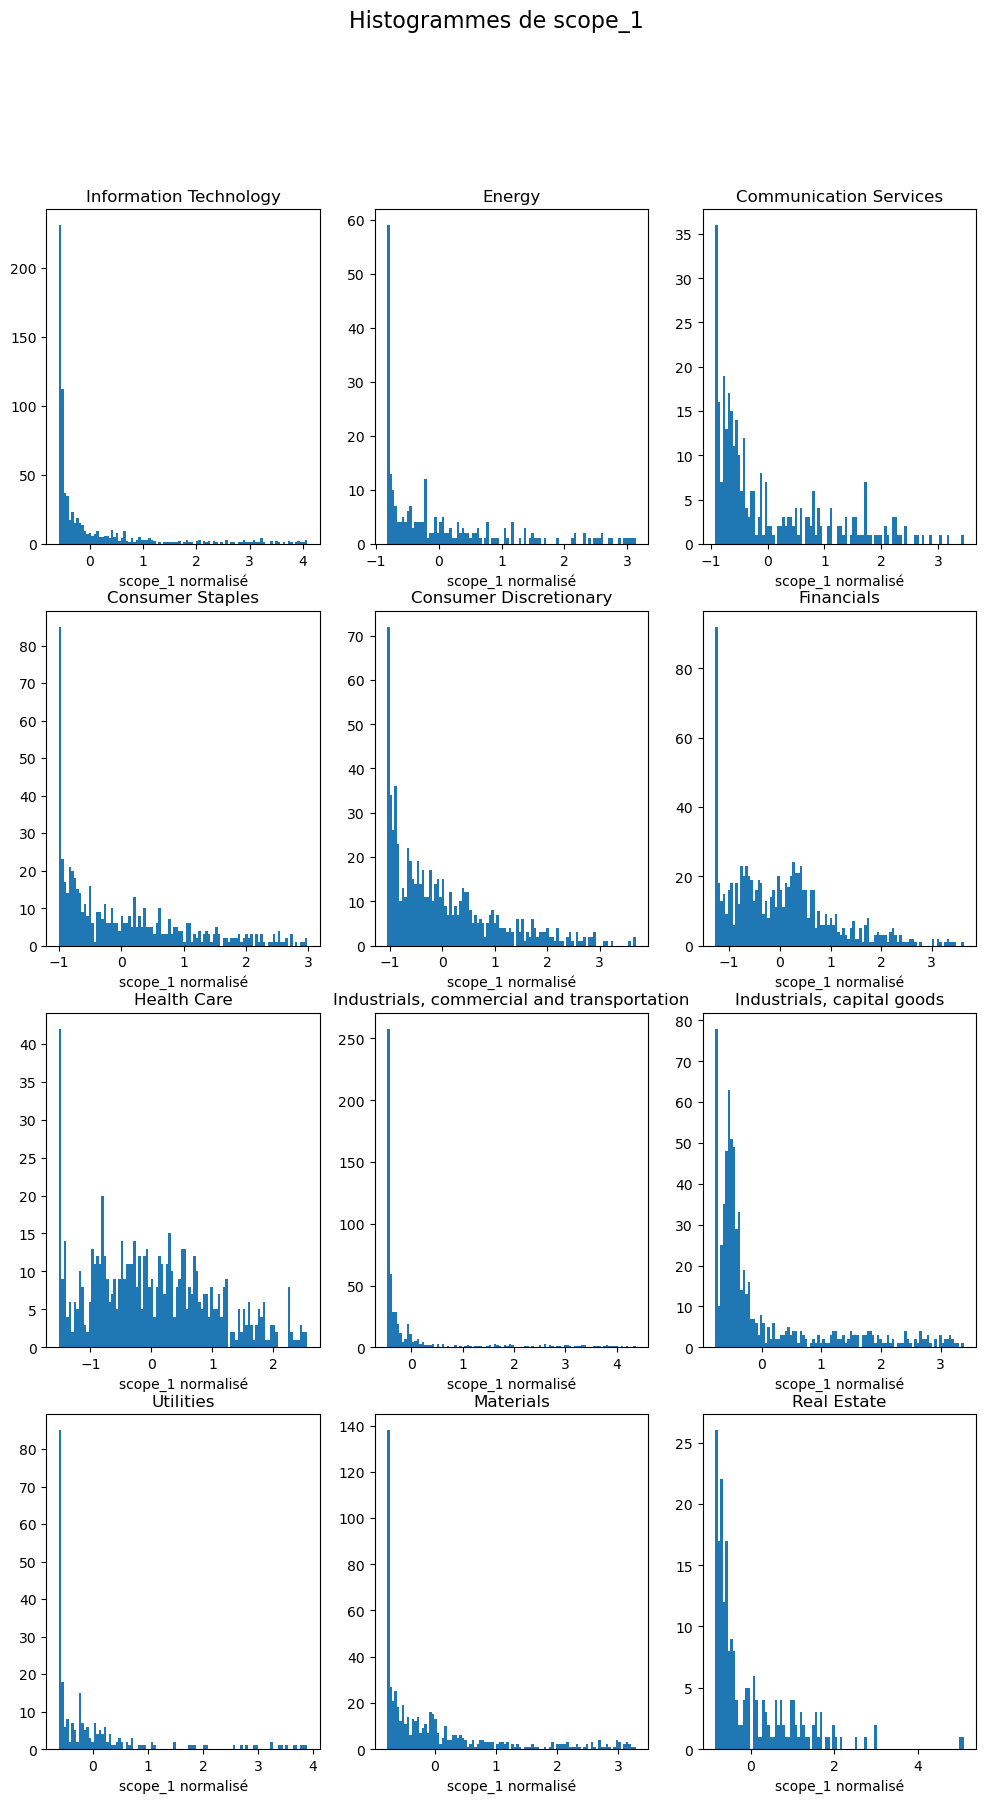

In [181]:
visualisation_hist("scope_1", 0.1)

Nombres d'entreprises mises de côté par secteur, en prenant le quantile 90.0%
Information Technology : 84
Energy : 28
Communication Services : 37
Consumer Staples : 68
Consumer Discretionary : 82
Financials : 101
Health Care : 79
Industrials, commercial and transportation : 63
Industrials, capital goods : 79
Utilities : 28
Materials : 67
Real Estate : 25


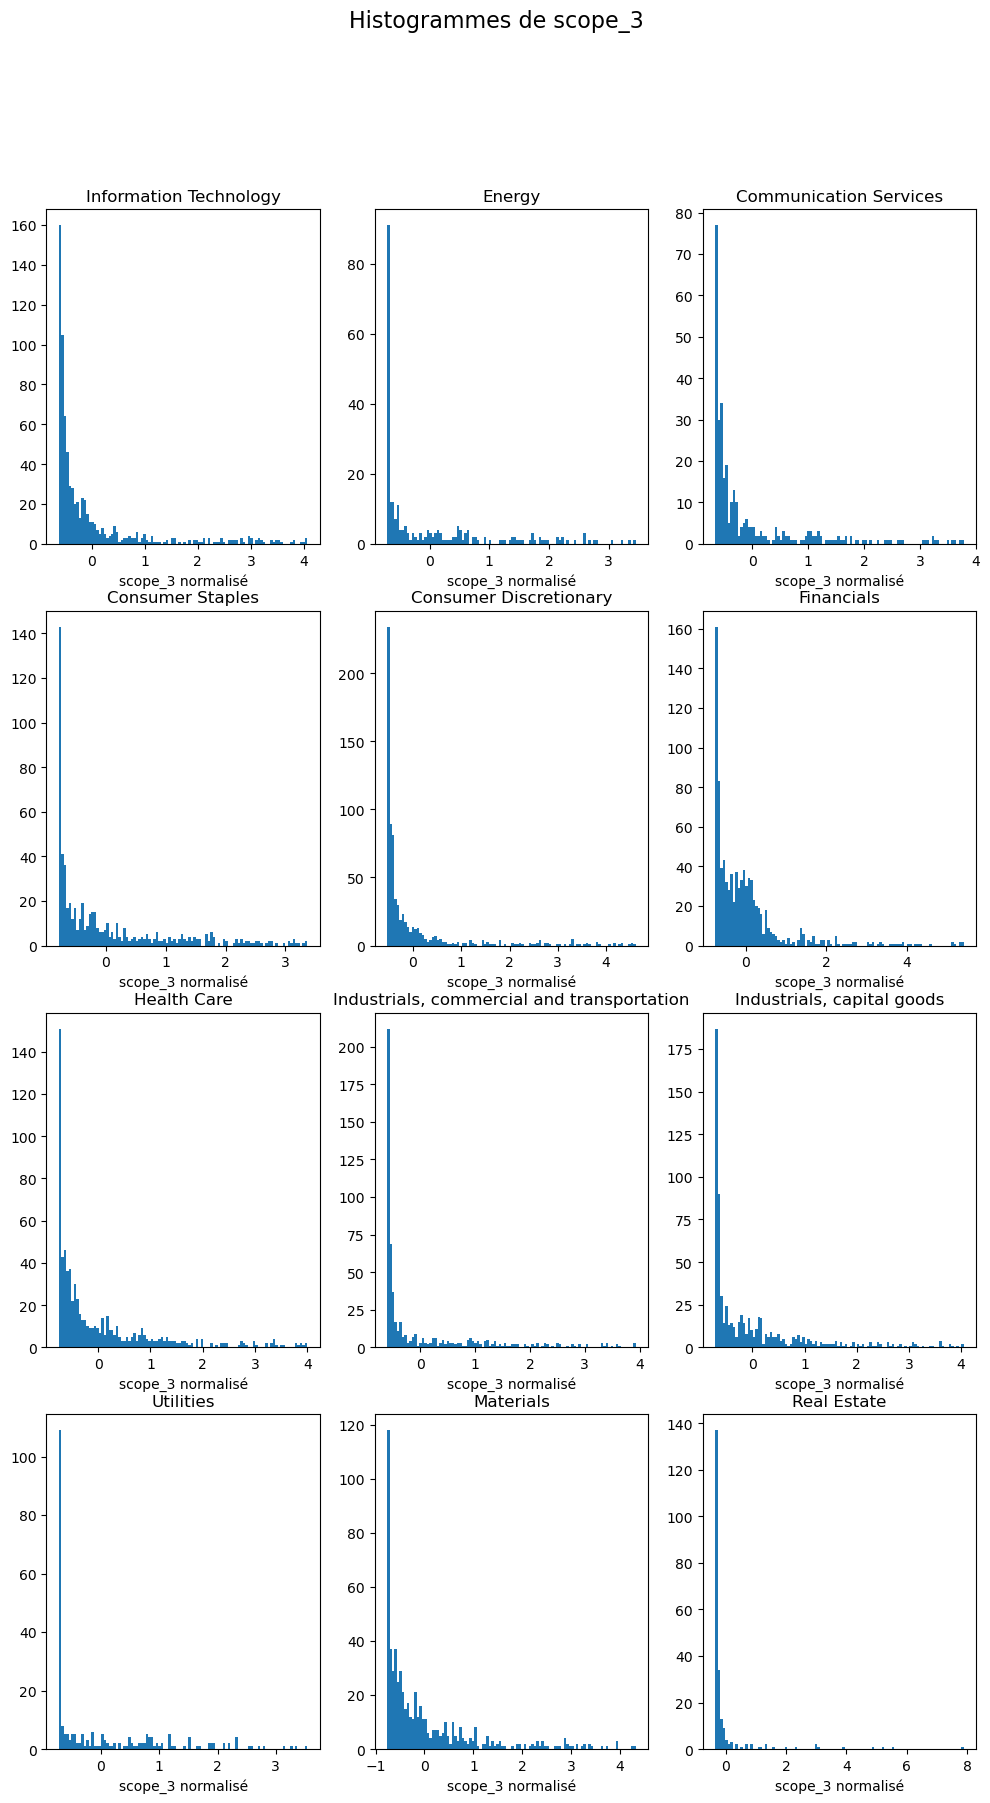

In [182]:
visualisation_hist("scope_3", 0.1)

On voit que en scope 3, on a beaucoup plus de valeurs proches de zéro. Cela peut être dû à : 1) plus d'outliers pour cette scope, ce qui fait ramener les autres entreprises proches de la moyenne relativement (on le voit dans les valeurs prises sur l'axe des abscisses, plus importantes pour le scope 3), 2) "un moins bon reporting" des entreprises, qui ne compte que peu d'émissions en scope 3, ce qui fait que celles qui jouent le jeu et compte bien ont des émissions bien plus importantes.

## Position sectorielle scope 1 et 3

On va relier la "position sectorielle" des entreprises en scope 1 et 3.

In [15]:
def assign_colors(data, column):
    unique_values = data[column].unique()
    palette = sns.color_palette("husl", len(unique_values))
    color_dict = dict(zip(unique_values, palette))
    return color_dict

In [14]:
def pos(sec) :
    df = data.loc[data["secteur"] == sec]
    df = df.dropna(subset = ["scope_1", "scope_3"])
    df = df.groupby("company_id").agg({
        "scope_1": "mean",
        "scope_3": "mean",
        "primary_industry": "first"
    }).reset_index()
    
    df['classement_scope_1'] = df["scope_1"].rank(ascending=False)
    df['classement_scope_3'] = df["scope_3"].rank(ascending=False)
    return df

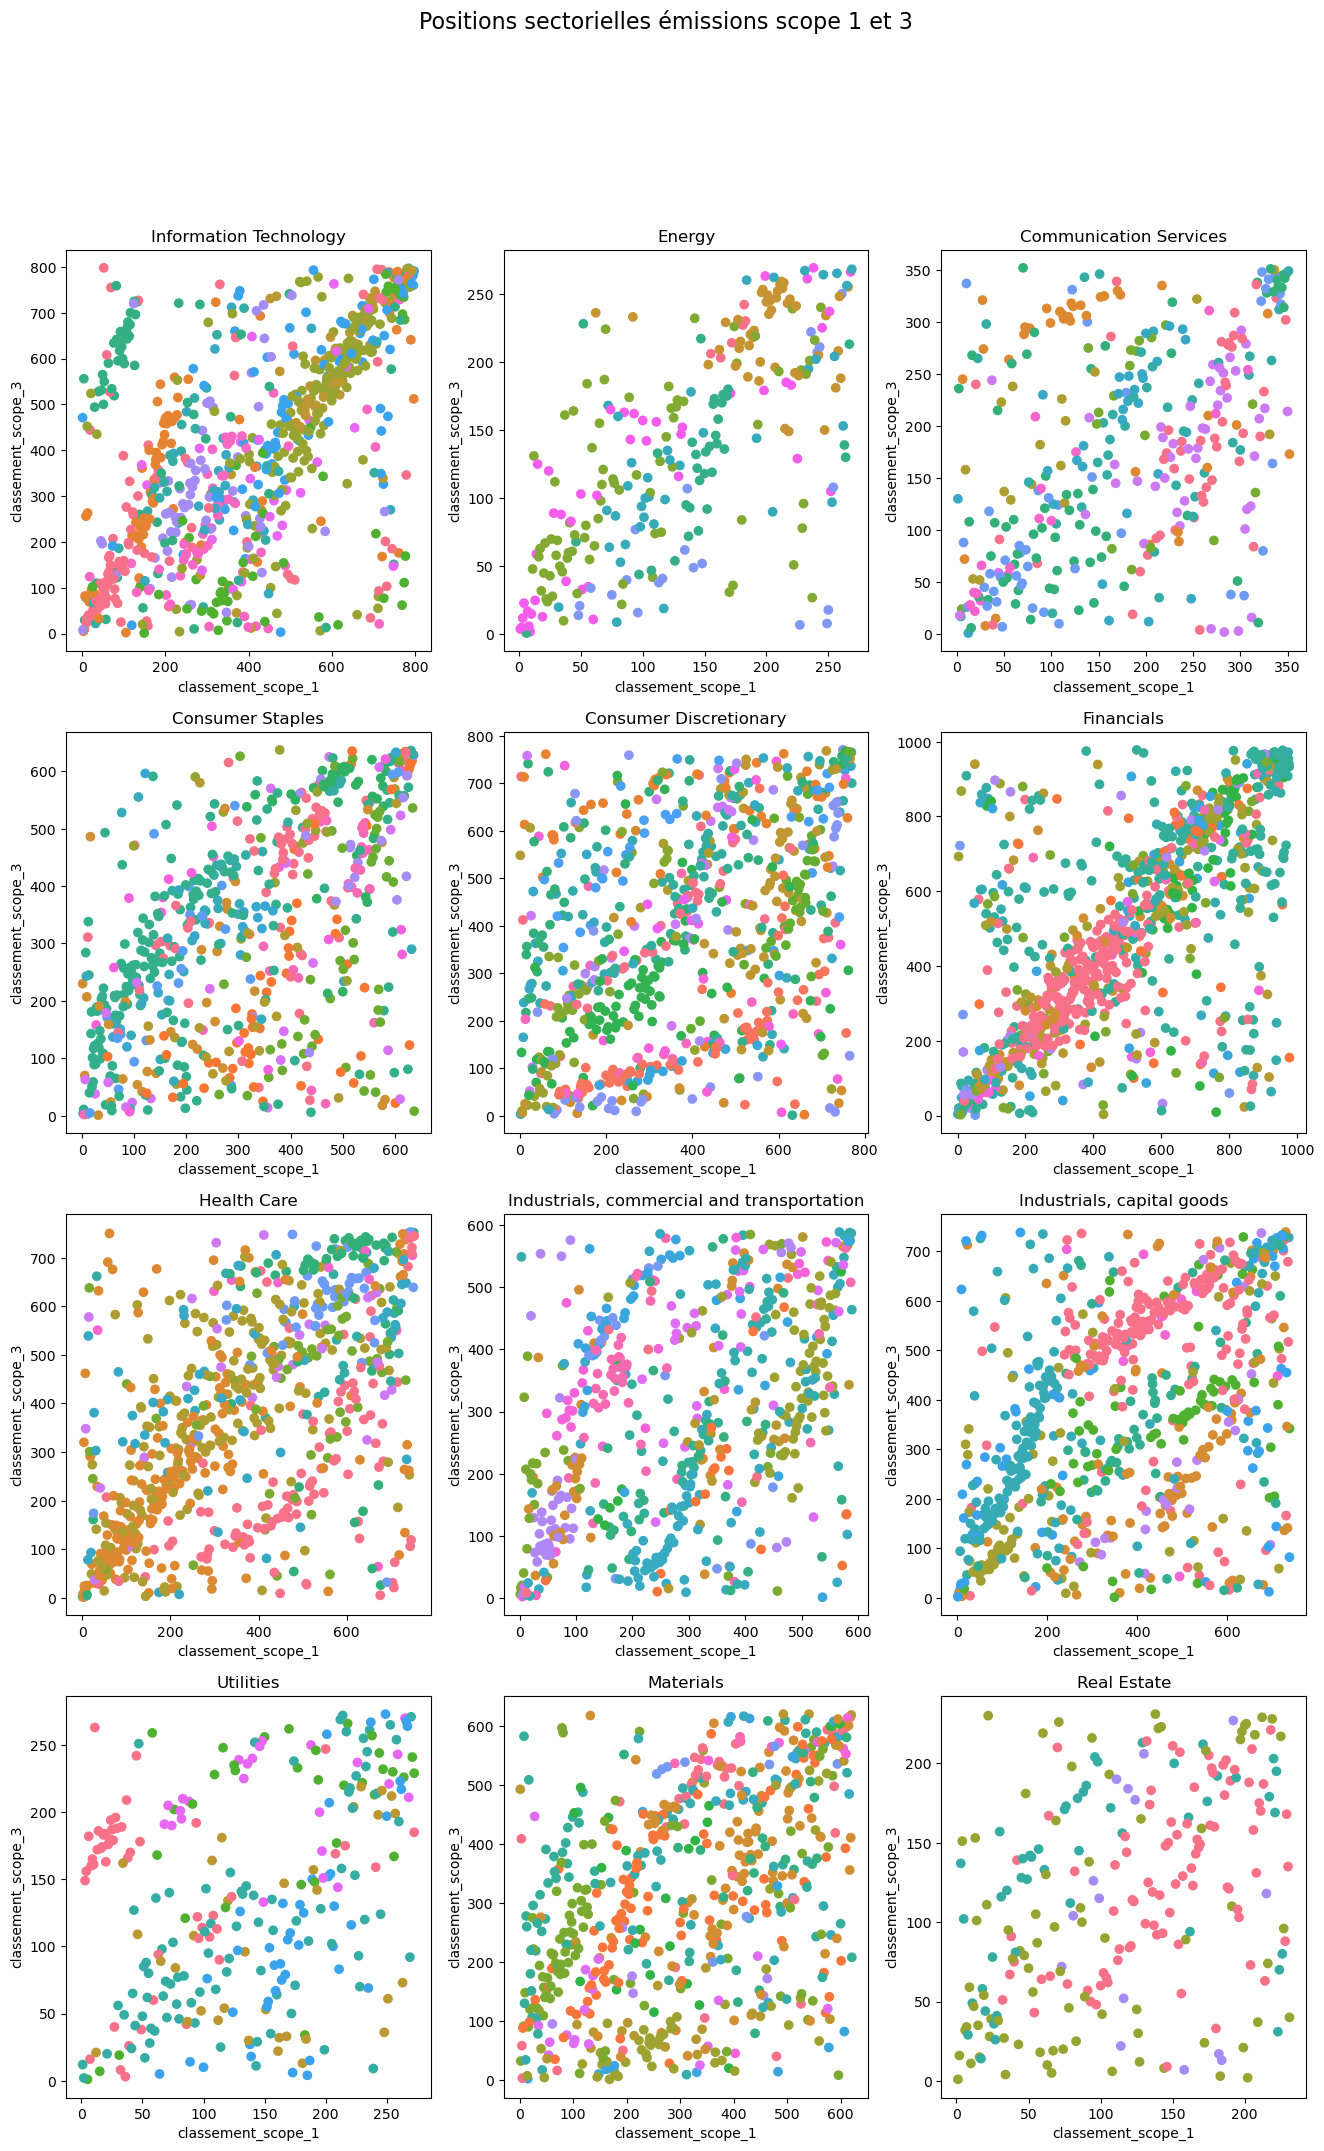

In [17]:
plt.figure(figsize=(16, 24))

i = 1
for s in secteurs:
    df = pos(s)
    
    # Obtenez les couleurs associées aux industries
    color_dict = assign_colors(df, "primary_industry")
    colors = df["primary_industry"].map(color_dict)
    
    plt.subplot(4, 3, i)
    plt.scatter(df["classement_scope_1"], df["classement_scope_3"], c=colors)
    plt.title(s)
    plt.xlabel("classement_scope_1")
    plt.ylabel("classement_scope_3")
    
    # Ajoutez une légende
    unique_industries = df["primary_industry"].unique()
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=ind, markerfacecolor=color_dict[ind], markersize=10) for ind in unique_industries]
    #plt.legend(handles=legend_handles, title="Primary Industry")
    
    i += 1

plt.suptitle("Positions sectorielles émissions scope 1 et 3", fontsize=16)
plt.show()

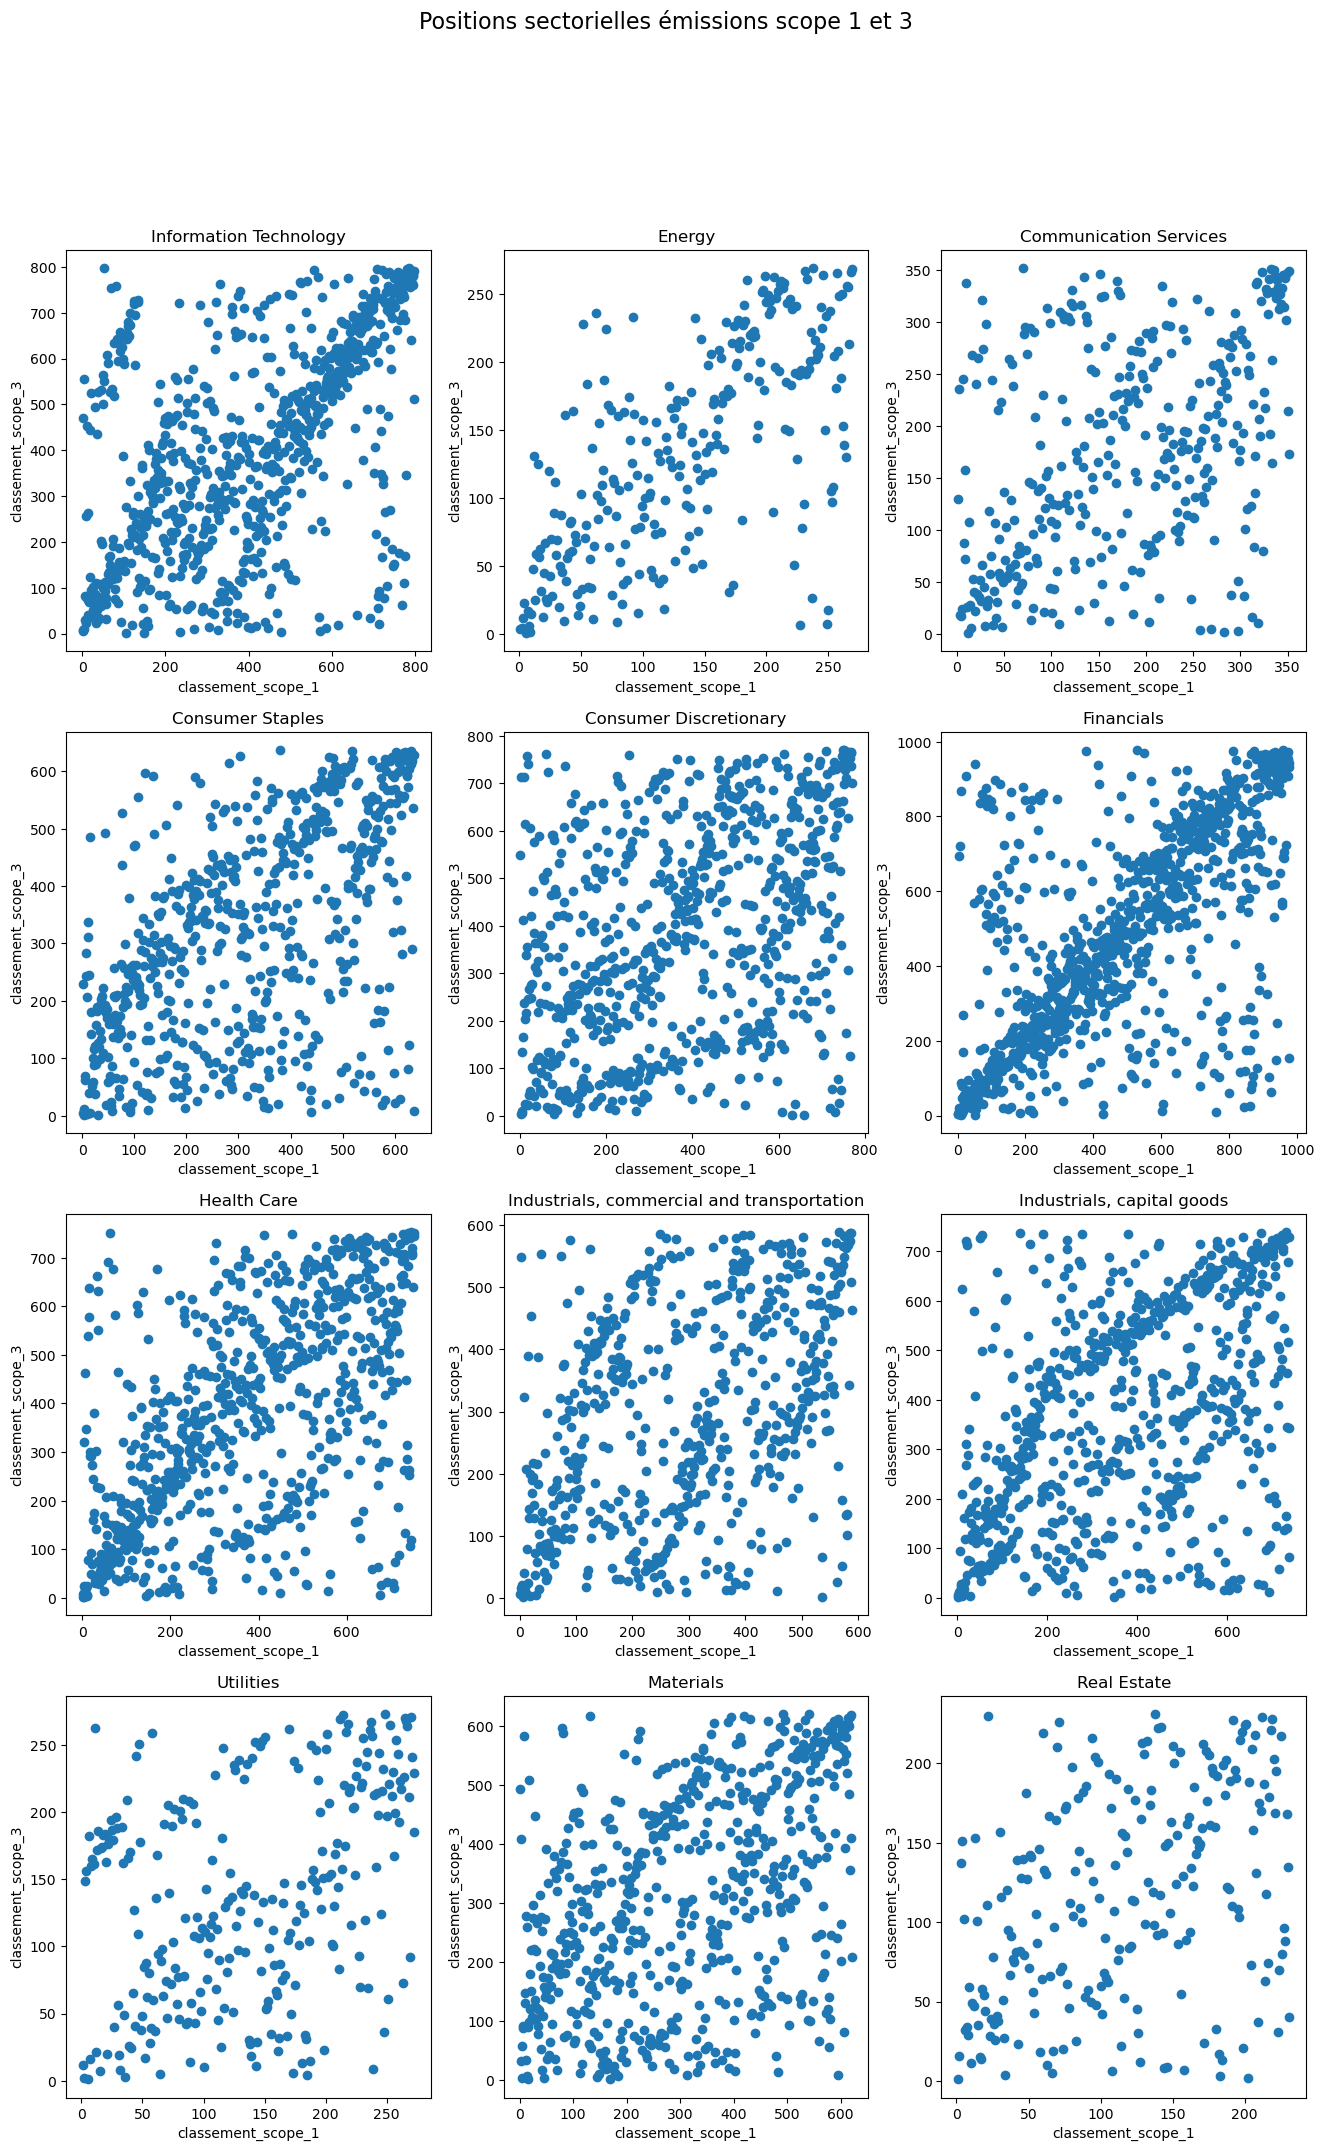

In [167]:
plt.figure(figsize=(16, 24))
    
i = 1
for s in secteurs :
    df = pos(s)
    plt.subplot(4,3,i)
    plt.scatter(df['classement_scope_1'], df['classement_scope_3'])
    plt.title(s)
    plt.xlabel('classement_scope_1')
    plt.ylabel('classement_scope_3')
    i += 1
    
plt.suptitle("Positions sectorielles émissions scope 1 et 3", fontsize=16)
plt.show()

## Relation entre taille de l'entreprise et "écart à la moyenne/médiane"

On étudie la relation qu'il peut y avoir entre taille de l'entreprise (en termes d'employés) et son écart à la moyenne sectorielle.

In [168]:
def ecart(scope, sec, per) :
    df = data.loc[data["secteur"] == sec]
    df = df.dropna(subset = scope)
    df = df.groupby('company_id').agg({scope : 'mean', 'employees': 'mean'}).reset_index()
    
    quantile = df[scope].quantile(1 - per)
    df = df[df[scope] <= quantile]
    
    mean = df[scope].mean()
    med = df[scope].median()
    var = df[scope].var()
    
    df["ecart_mean"] = (df[scope]-mean)/np.sqrt(var)
    df["ecart_med"] = (df[scope]-med)/np.sqrt(var)
    return df

In [183]:
def visualisation2(scope, x, per) :

    plt.figure(figsize=(16, 24))
    
    i = 1
    for s in secteurs :
        if x == 0 : m = "ecart_mean"
        else : m = "ecart_med"
            
        df = ecart(scope, s, per)
        plt.subplot(4,3,i)
        plt.scatter(df["employees"]/df["employees"].mean(), df[m])
        plt.title(s)
        plt.xlabel("employees normalisé")
        plt.ylabel(m)
        i += 1
    
    plt.suptitle("Relation entre taille (employés) et " + m + " des émissions " + scope, fontsize=16)
    plt.show()

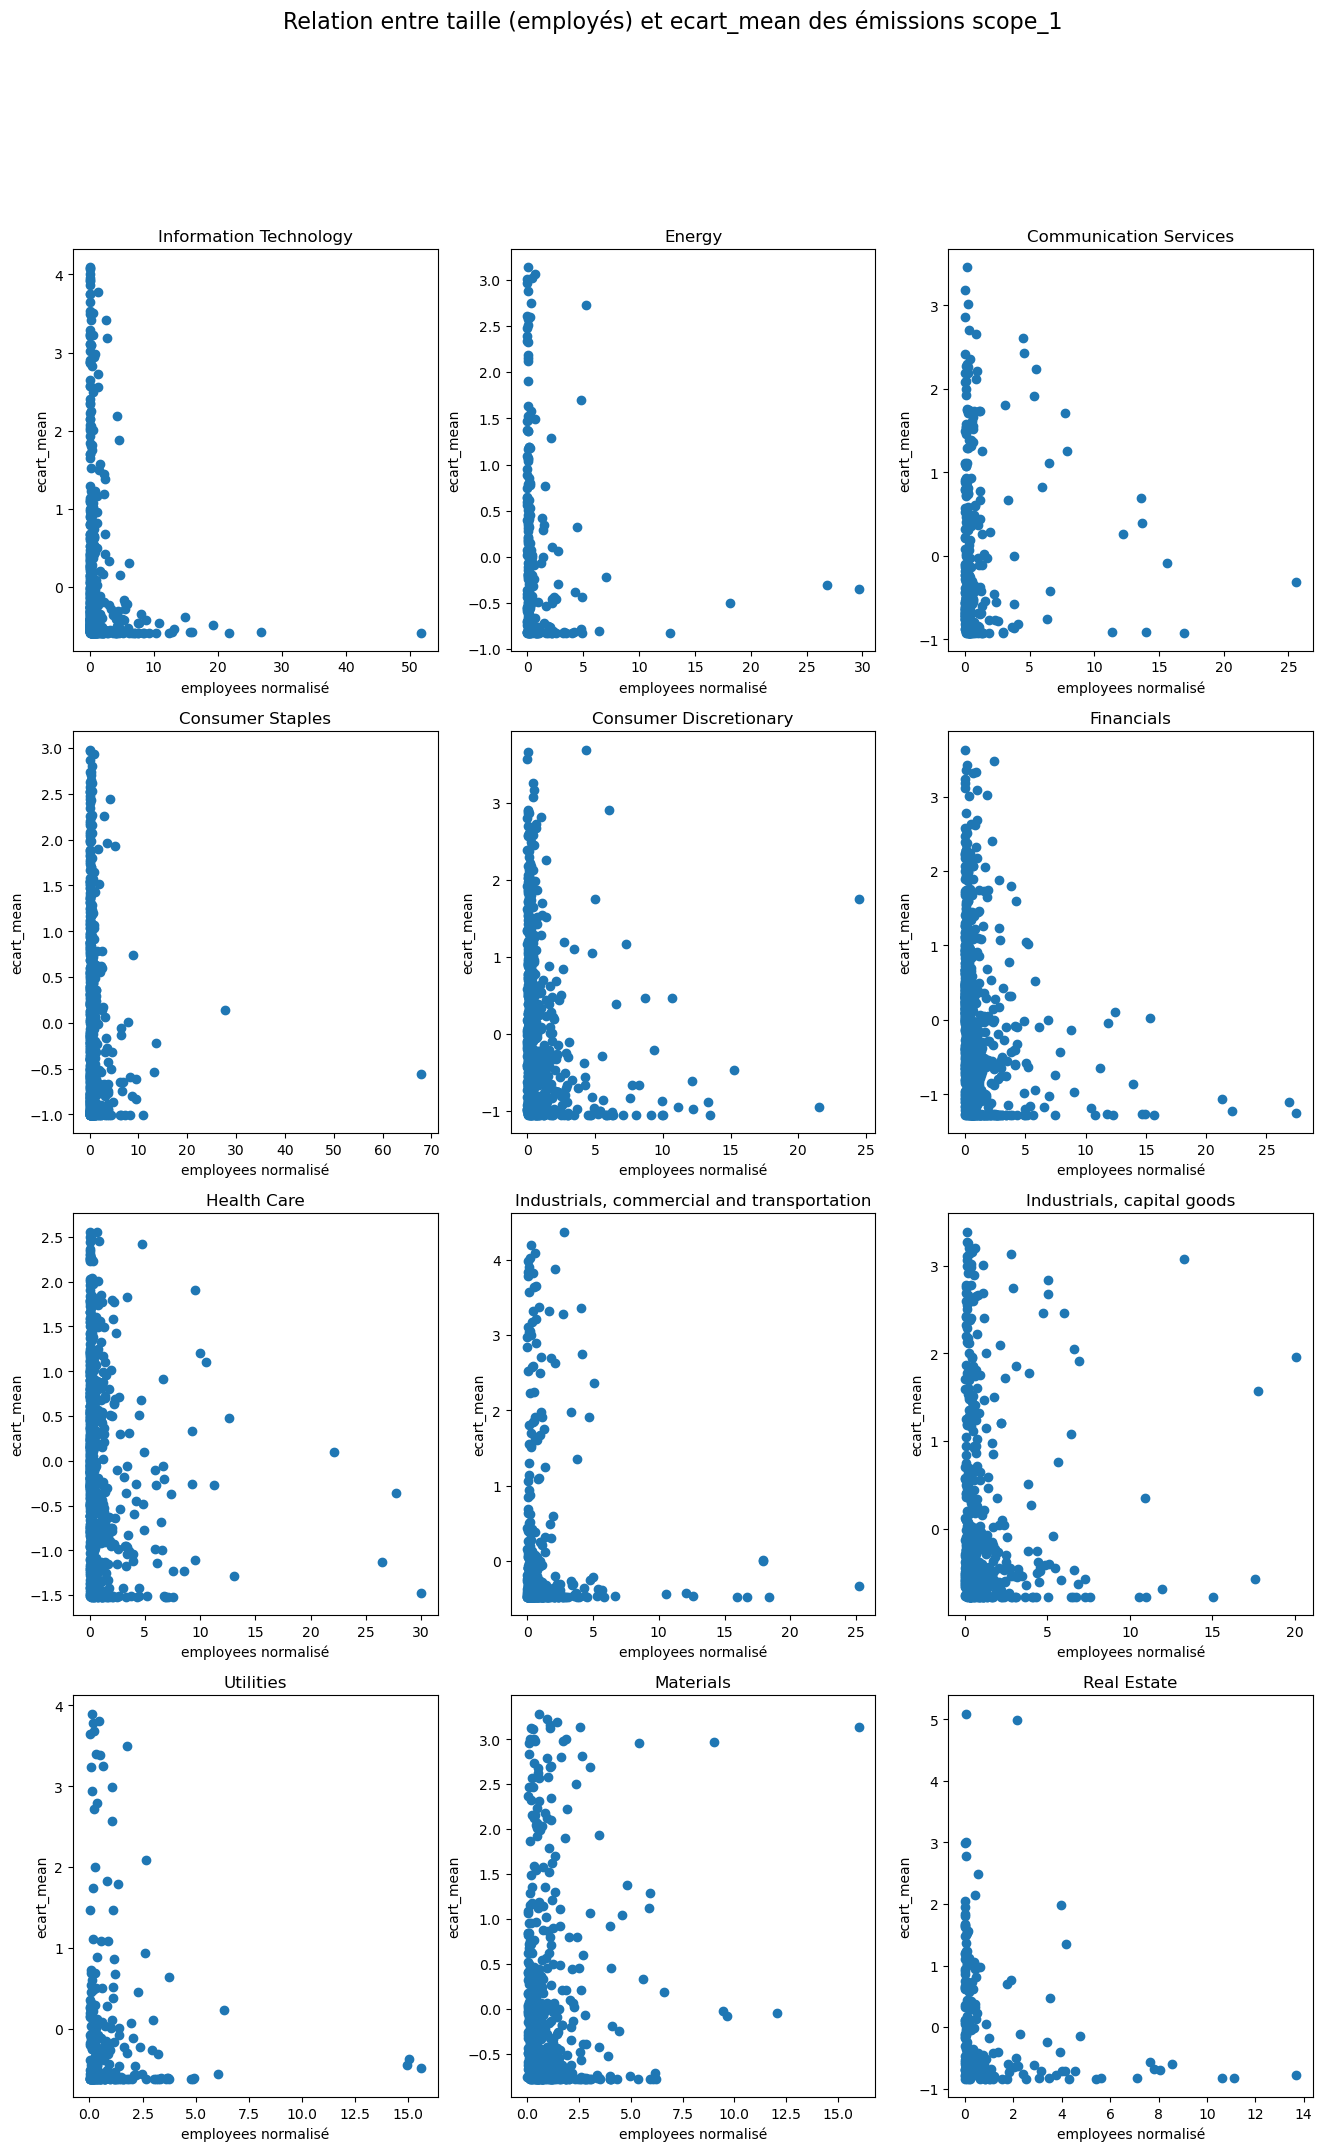

In [184]:
visualisation2("scope_1", 0, 0.1)

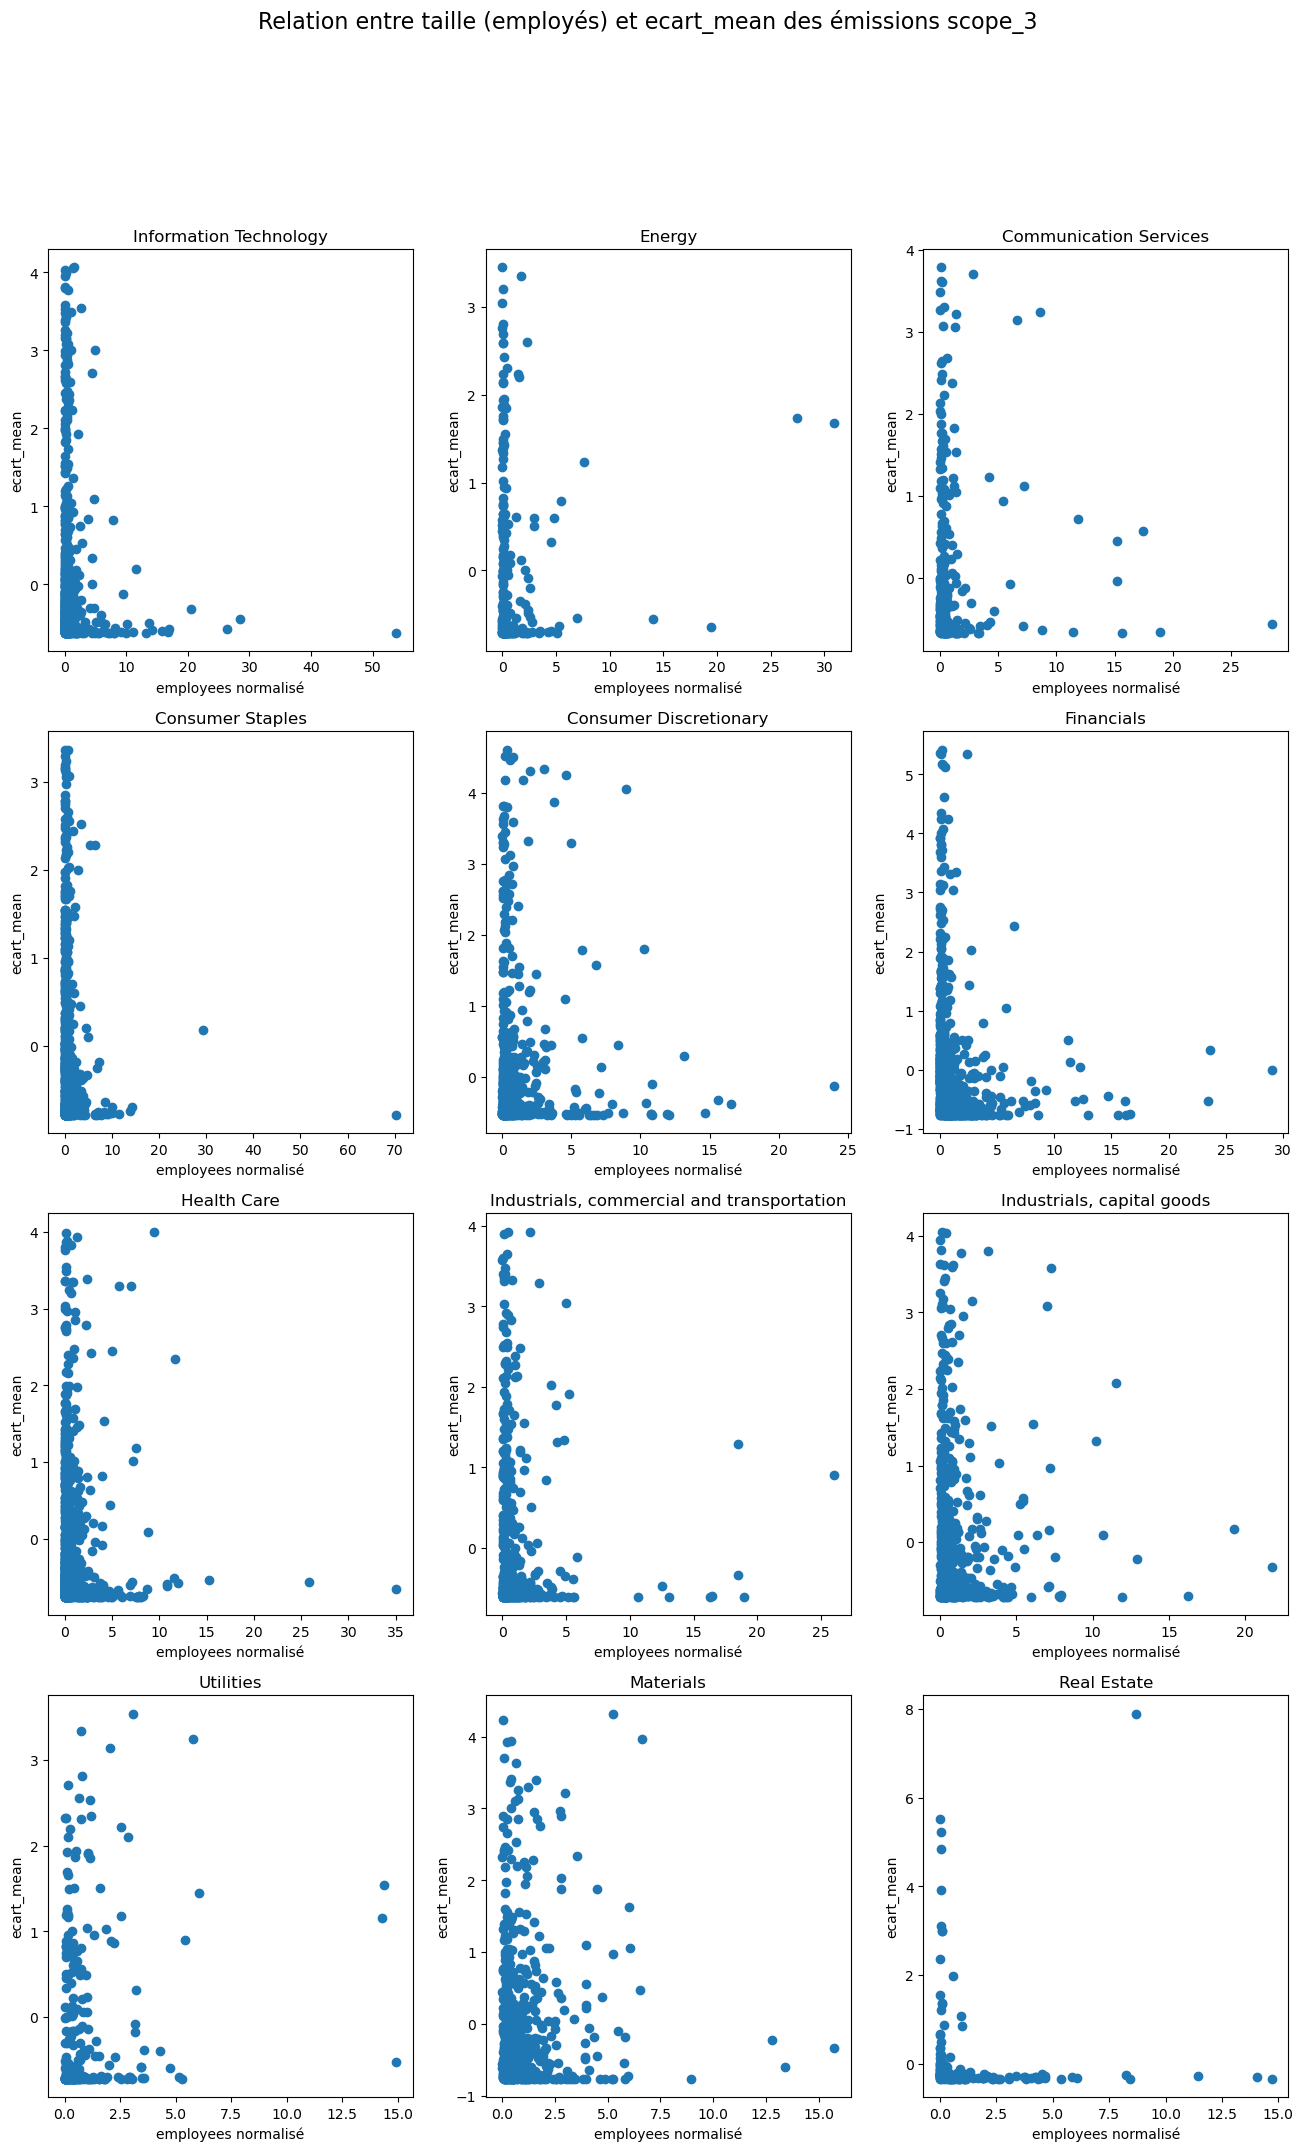

In [185]:
visualisation2("scope_3", 0, 0.1)

## Simplement, relation entre scope 1 et 3 par secteur

In [188]:
def visualisation3(per) :
    plt.figure(figsize=(16, 24))
    i = 1
    
    for sec in secteurs :
        df = data.loc[data["secteur"] == sec]
        df = df.dropna(subset = ["scope_1", "scope_3"])
        df = df.groupby('company_id')[["scope_1", "scope_3"]].mean().reset_index()
    
        quantile1 = df["scope_1"].quantile(1 - per)
        df = df[df["scope_1"] <= quantile1]
        quantile3 = df["scope_3"].quantile(1 - per)
        df = df[df["scope_3"] <= quantile3]

        plt.subplot(4,3,i)
        plt.scatter(df['scope_1'], df['scope_3'])
        plt.title(s)
        plt.xlabel('scope_1')
        plt.ylabel('scope_3')
        
        i += 1
        
    plt.suptitle("Relations sectorielles scope 1 et 3", fontsize=16)
    plt.show()

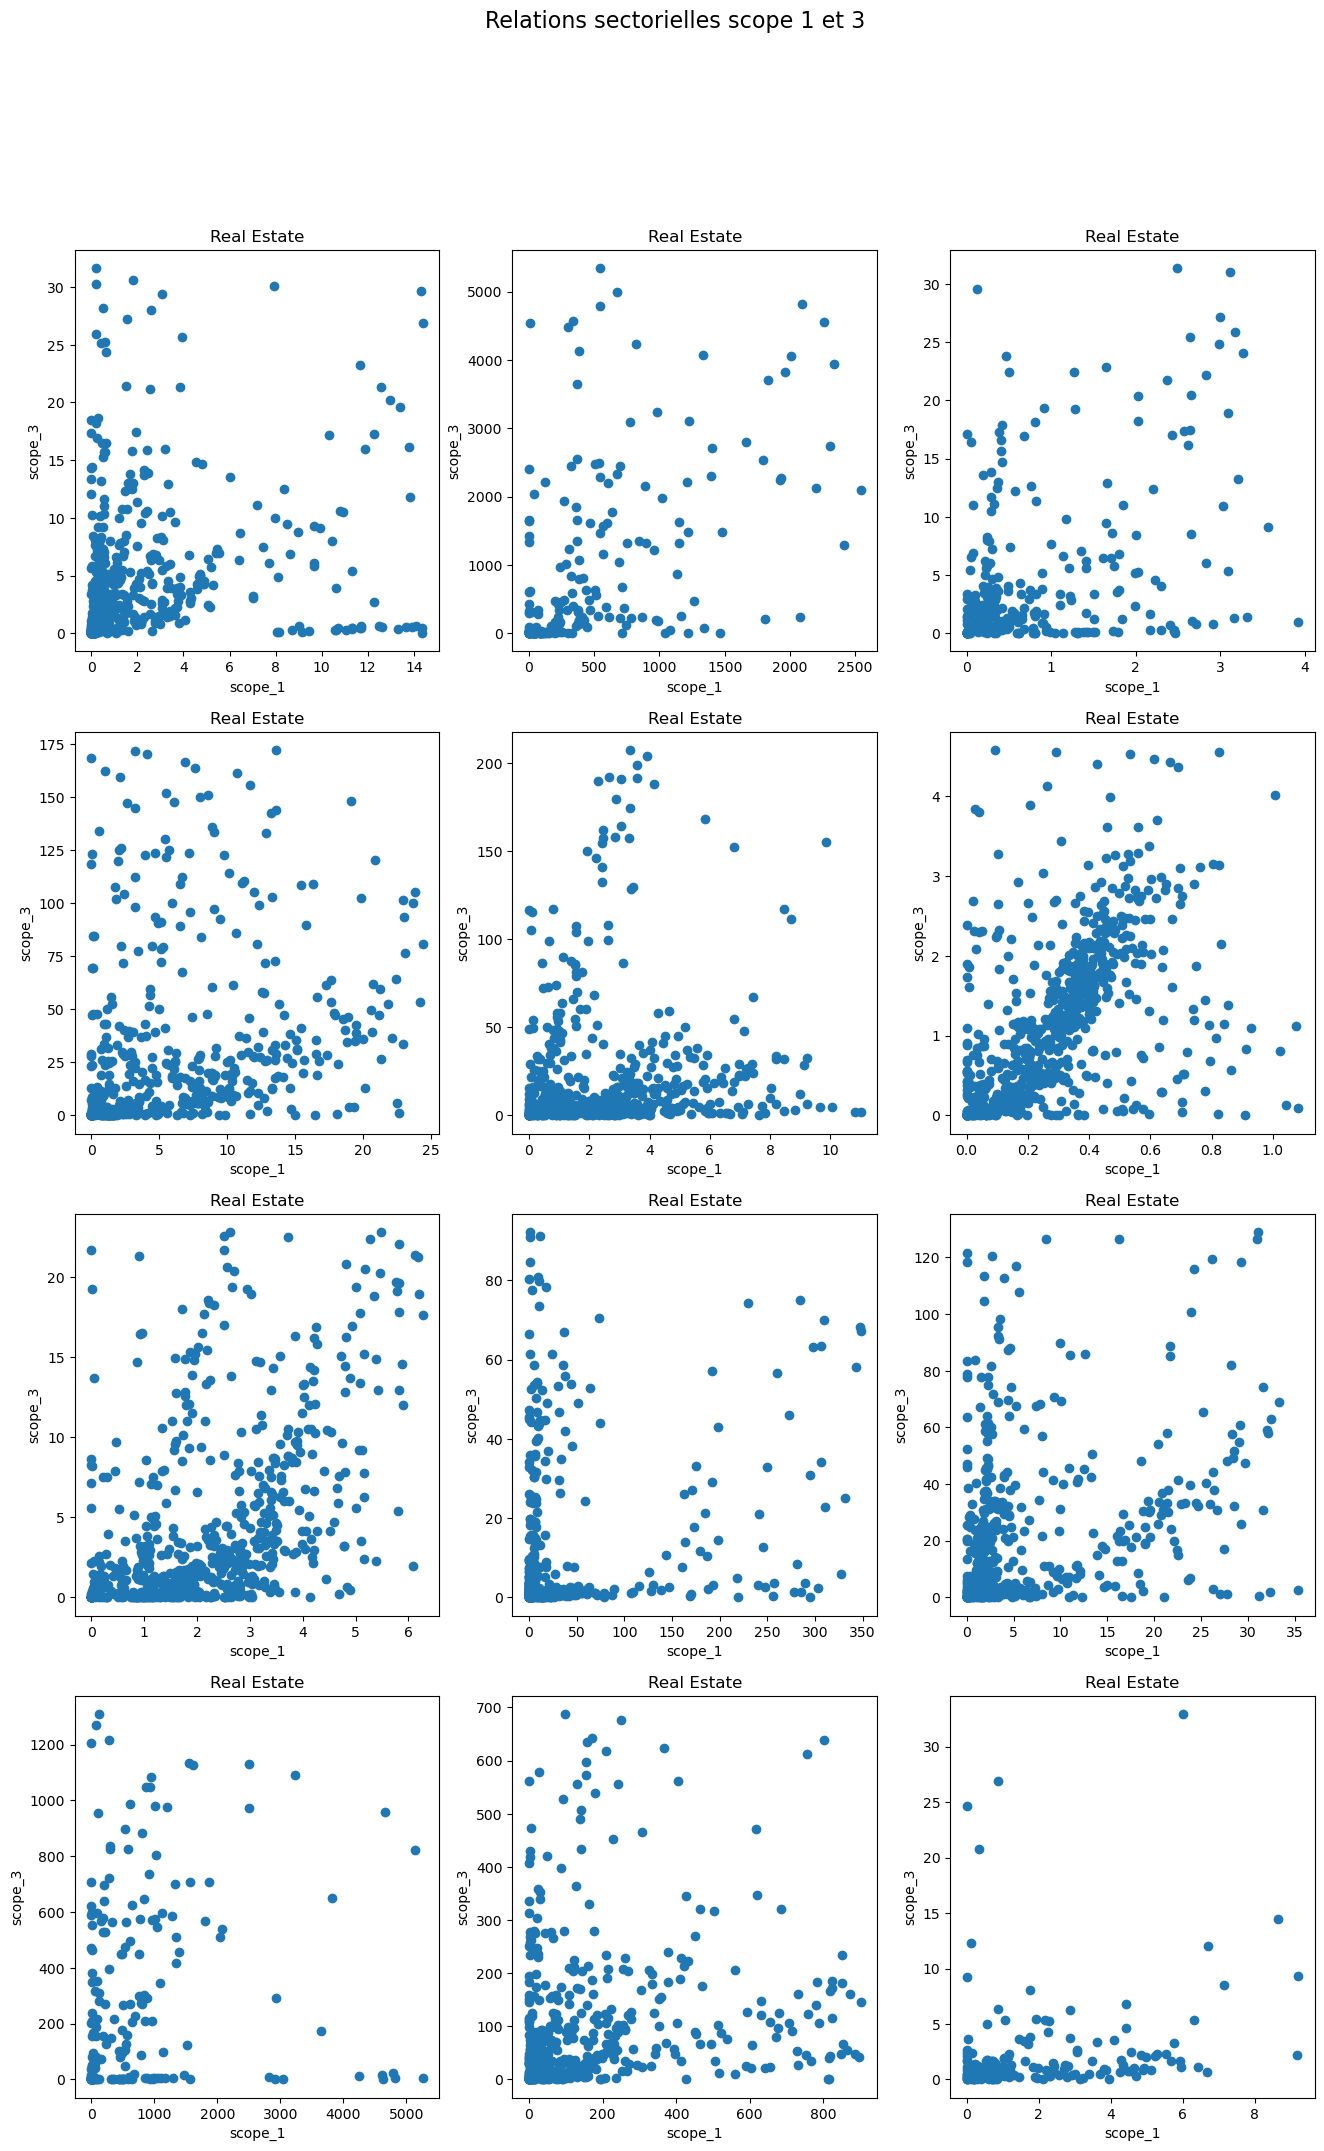

In [189]:
visualisation3(0.1)